In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_score, 
    recall_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.model_selection import train_test_split

In [102]:
df = pd.read_csv("../our_analyses/dataset_prepared.csv")

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              15000 non-null  object 
 1   duration_ms       15000 non-null  int64  
 2   explicit          15000 non-null  bool   
 3   popularity        15000 non-null  int64  
 4   artists           15000 non-null  object 
 5   album_name        15000 non-null  object 
 6   danceability      15000 non-null  float64
 7   energy            15000 non-null  float64
 8   key               15000 non-null  int64  
 9   loudness          15000 non-null  float64
 10  mode              15000 non-null  int64  
 11  speechiness       15000 non-null  float64
 12  acousticness      15000 non-null  float64
 13  instrumentalness  15000 non-null  float64
 14  liveness          15000 non-null  float64
 15  valence           15000 non-null  float64
 16  tempo             15000 non-null  float6

In [104]:
# Definizione dei macro raggruppamenti
macro_genre = {
    'electronic ': ['techno', 'idm', 'industrial', 'chicago-house', 'breakbeat'],
    'metal': ['black-metal'],
    'pop': ['j-idol', 'mandopop', 'pop', 'afrobeat'],
    'international': ['iranian', 'spanish','indian','brazil'],
    'relaxing': ['sleep','disney','study'],
    'other': ['happy', 'forro','bluegrass']
}


df = pd.DataFrame(df)
# Applicazione del raggruppamento
df['macro_genre'] = df['genre'].apply(lambda x: next((group for group, genres in macro_genre.items() if x in genres), 'other'))


from sklearn.preprocessing import LabelEncoder

# Creazione di un oggetto LabelEncoder
label_encoder = LabelEncoder()

# Fit e trasformazione della colonna 'macro_genre' nel DataFrame
df['macro_genre_encoded'] = label_encoder.fit_transform(df['macro_genre'])

# Visualizzazione dei mapping tra categorie e valori numerici
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping delle categorie a valori numerici:")
print(category_mapping)

# elimino macro genre x avere solo macro_genre_encoded
df = df.drop('macro_genre' , axis = 1)
df = df.drop('genre' , axis = 1)
df = df.drop('name' , axis = 1)
df = df.drop('album_name' , axis = 1)
df = df.drop('artists' , axis = 1)

Mapping delle categorie a valori numerici:
{'electronic ': 0, 'international': 1, 'metal': 2, 'other': 3, 'pop': 4, 'relaxing': 5}


# partitioning

In [105]:
# passo x tutto in array
# e in y il target attribute

X = df.values
y = np.array(df['macro_genre_encoded'])

np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([3750, 3000,  750, 3000, 2250, 2250], dtype=int64))

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# without stratify
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.25 0.2  0.05 0.2  0.15 0.15]
[0.25295238 0.19714286 0.05161905 0.19961905 0.14819048 0.15047619]
[0.24311111 0.20666667 0.04622222 0.20088889 0.15422222 0.14888889]


In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

# with stratify
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.25 0.2  0.05 0.2  0.15 0.15]
[0.25 0.2  0.05 0.2  0.15 0.15]
[0.25 0.2  0.05 0.2  0.15 0.15]


In [108]:
#train e test divisi ffa vedere numero 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10500, 16) (4500, 16) (10500,) (4500,)


# Normalization

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# KNN

In [110]:
clf = KNeighborsClassifier(n_neighbors=54, metric="euclidean", weights="uniform")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=54)

In [111]:
y_test_pred = clf.predict(X_test_norm)
y_test_pred

array([0, 0, 4, ..., 5, 1, 0])

In [112]:
clf.score(X_test_norm, y_test)

0.7942222222222223

In [128]:
(y_test_pred == y_test).sum() / len(y_test)

0.7942222222222223

In [114]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.7942222222222223


In [115]:
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"), "\n")
print("F1 micro:", f1_score(y_test, y_test_pred, average="micro"), "\n")
unique_labels = np.unique(y_test)


#for single label
for label in unique_labels:
    print(f"F1 macro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="macro"))
print("\n")
for label in unique_labels:
    print(f"F1 micro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="micro"))

F1 macro: 0.7840552882091951 

F1 micro: 0.7942222222222223 

F1 macro for label 0: 0.8498006202924238
F1 macro for label 1: 0.763943661971831
F1 macro for label 2: 0.7219730941704036
F1 macro for label 3: 0.7727022564667033
F1 macro for label 4: 0.7344947735191637
F1 macro for label 5: 0.8614173228346456


F1 micro for label 0: 0.8498006202924238
F1 micro for label 1: 0.763943661971831
F1 micro for label 2: 0.7219730941704036
F1 micro for label 3: 0.7727022564667033
F1 micro for label 4: 0.7344947735191637
F1 micro for label 5: 0.8614173228346456


In [116]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1125
           1       0.77      0.75      0.76       900
           2       0.73      0.72      0.72       225
           3       0.77      0.78      0.77       900
           4       0.69      0.78      0.73       675
           5       0.92      0.81      0.86       675

    accuracy                           0.79      4500
   macro avg       0.79      0.78      0.78      4500
weighted avg       0.80      0.79      0.80      4500



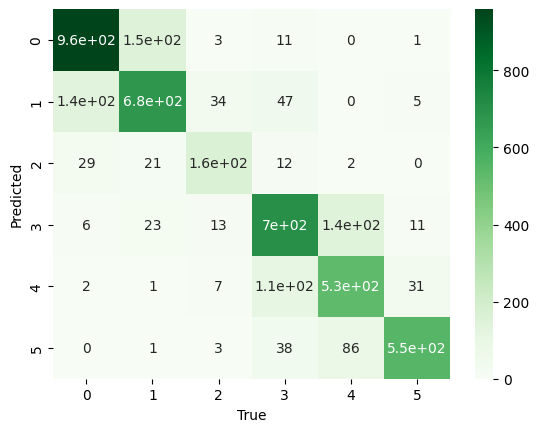

In [117]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [118]:
# Return probability estimates for the test data X.
y_test_pred_proba = clf.predict_proba(X_test_norm) 
y_test_pred_proba[0:10]

array([[0.77777778, 0.12962963, 0.01851852, 0.07407407, 0.        ,
        0.        ],
       [0.98148148, 0.01851852, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.05555556, 0.05555556, 0.24074074, 0.64814815,
        0.        ],
       [0.85185185, 0.09259259, 0.01851852, 0.01851852, 0.01851852,
        0.        ],
       [0.        , 0.01851852, 0.01851852, 0.40740741, 0.53703704,
        0.01851852],
       [0.25925926, 0.62962963, 0.05555556, 0.05555556, 0.        ,
        0.        ],
       [0.05555556, 0.01851852, 0.11111111, 0.35185185, 0.46296296,
        0.        ],
       [0.22222222, 0.12962963, 0.14814815, 0.42592593, 0.07407407,
        0.        ],
       [0.        , 0.03703704, 0.        , 0.38888889, 0.51851852,
        0.05555556],
       [0.51851852, 0.31481481, 0.        , 0.14814815, 0.01851852,
        0.        ]])

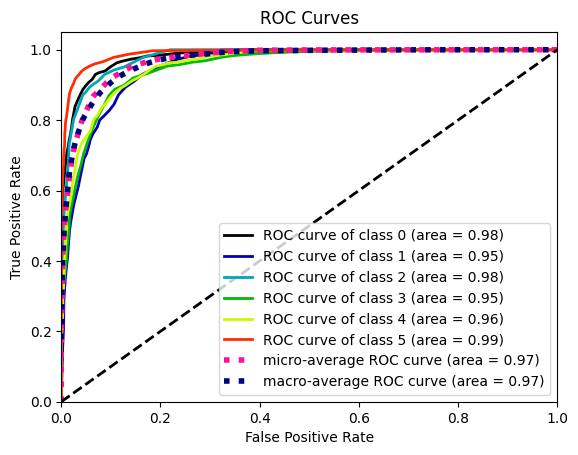

In [119]:
plot_roc(y_test, y_test_pred_proba)
plt.show()

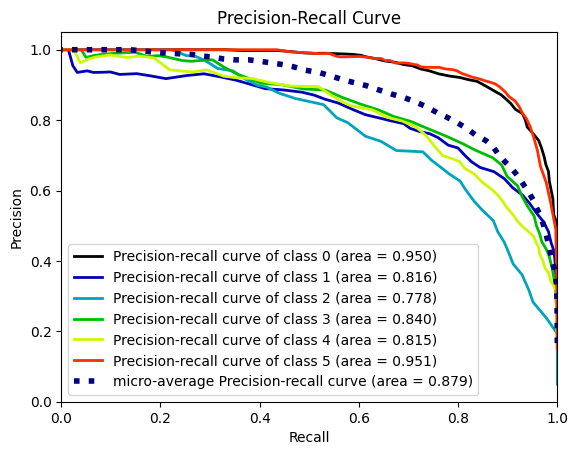

In [120]:
plot_precision_recall(y_test, y_test_pred_proba)
plt.show()

In [134]:
N = 100
err = 0

for i in range(N):
    # stratified holdout
    X_rh_train, X_rh_test, y_rh_train, y_rh_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    # normalize train set
    norm.fit(X_rh_train)
    X_rh_train_norm = norm.transform(X_rh_train)
    X_rh_test_norm = norm.transform(X_rh_test)

    # initialize and fit classifier
    clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
    clf.fit(X_rh_train_norm, y_rh_train)

    # computing error
    acc = clf.score(X_rh_test_norm, y_rh_test)
    err += 1 - acc

print("Overall error estimate:", err/N)

Overall error estimate: 0.1781022222222222


# cross validation

from sklearn.model_selection import cross_val_score
k = 10

In [129]:
from sklearn.model_selection import cross_val_score
k = 10

In [130]:
# initialize classifier
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")

scores = cross_val_score(clf, X_train_norm, y_train, cv=k) # we call the 10 cross validation only on the training portion of our data
scores

array([0.82380952, 0.81714286, 0.81619048, 0.81333333, 0.80190476,
       0.81428571, 0.82380952, 0.8152381 , 0.83142857, 0.82380952])

In [131]:
print("Overall error estimate:", 1 - scores.mean()) 

Overall error estimate: 0.1819047619047618


In [132]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.8181 (+/- 0.01)


In [133]:
# scoring default is accuracy
cross_val_score(clf, X_train_norm, y_train, cv=k, scoring='f1_macro')

array([0.81787576, 0.79775198, 0.79747383, 0.80696697, 0.79632393,
       0.79970121, 0.81601389, 0.79511144, 0.82351706, 0.80977684])